### 建立.csv文件读取线程

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from threading import Thread
from collections import OrderedDict
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from functools import reduce
import warnings
warnings.filterwarnings('ignore')
one = OneHotEncoder()
one.fit([['刺网'], ['围网'], ['拖网']])

class ReadCsvThread(Thread):
    def __init__(self, csv_path, data):
        super().__init__()
        self.__csv_path = csv_path
        self.__data = data

    def run(self) -> None:
        # 数据预处理
        boat = pd.read_csv(self.__csv_path, delimiter=',')
        boat = boat[(boat['速度'] <= 20) & (boat['方向'] >= 0) & (boat['方向'] <= 360)]
        boat.sort_values(by='time', inplace=True, ascending=False, ignore_index=True)

        self.__data.append(boat)

### 展示三种作业的渔船轨迹

In [2]:
path = 'C:\\Users\\tanshiji\\PycharmProjects\\tianchi\\hy_round1_train_20200102\\hy_round1_train_20200102'
files = os.listdir(path)
data = []
step = 500
for i in range(0, len(files), step):
    threads = []
    for file in files[i:i+step]:
        t = ReadCsvThread(path + '\\' + file, data)
        t.start()
        threads.append(t)
    for t in threads:
        t.join()
    break
data = pd.DataFrame(data)
print('渔船初始数据')
print(data[0][0])
plt.rcParams['font.family']=['STFangsong']

t, w, c = [], [], []
for i in range(len(data)):
    if data[0][i]['type'].iloc[0] == '拖网':
        t.append(data[0][i][['x', 'y']])
    if data[0][i]['type'].iloc[0] == '围网':
        w.append(data[0][i][['x', 'y']])
    if data[0][i]['type'].iloc[0] == '刺网':
        c.append(data[0][i][['x', 'y']])

渔船初始数据
     渔船ID             x             y     速度   方向           time type
0      10  6.321032e+06  5.242805e+06   4.48  213  1110 11:49:36   拖网
1      10  6.322753e+06  5.244329e+06   3.29  212  1110 11:29:26   拖网
2      10  6.323664e+06  5.245091e+06  10.09  316  1110 11:19:25   拖网
3      10  6.324575e+06  5.245852e+06   3.62  226  1110 11:09:26   拖网
4      10  6.325587e+06  5.246723e+06   3.78  243  1110 10:59:23   拖网
..    ...           ...           ...    ...  ...            ...  ...
392    10  6.246119e+06  5.240828e+06   0.11   91  1107 12:55:08   拖网
393    10  6.246120e+06  5.240937e+06   0.32  330  1107 12:45:08   拖网
394    10  6.246119e+06  5.240828e+06   0.11  204  1107 12:35:32   拖网
395    10  6.246119e+06  5.240828e+06   0.22   50  1107 12:25:25   拖网
396    10  6.246120e+06  5.240937e+06   0.32    0  1107 12:15:43   拖网

[397 rows x 7 columns]


### 拖网

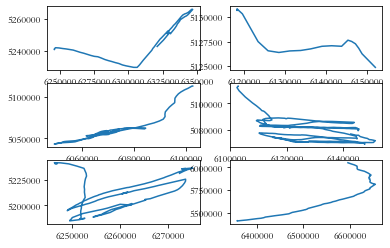

In [3]:
plt.xlabel('x')
plt.ylabel('y')
for i in range(6):
    plt.subplot(3, 2, i + 1)
    plt.plot(t[i]['x'], t[i]['y'])
plt.show()

### 围网

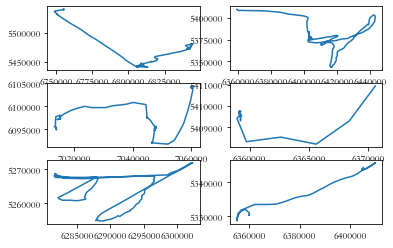

In [4]:
plt.xlabel('x')
plt.ylabel('y')
for i in range(6):
    plt.subplot(3, 2, i + 1)
    plt.plot(w[i]['x'], w[i]['y'])
plt.show()

### 刺网

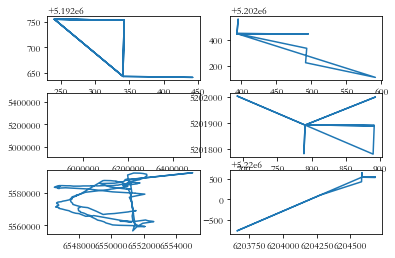

In [5]:
plt.xlabel('x')
plt.ylabel('y')
for i in range(6):
    plt.subplot(3, 2, i + 1)
    plt.plot(c[i]['x'], c[i]['y'])
plt.show()

In [6]:
def pre_processing(train, y, pro_data, pre_models):
    for model in pre_models:
        model.fit(train, y)
        train = model.transform(train)
        for i in range(len(pro_data)):
            pro_data[i] = model.transform(pro_data[i])
    return pro_data


def vote(clfs, clf_pre_models, x_train, y_train, x_val, y_val=None, names=None, ras=''):
    from sklearn.metrics import f1_score, accuracy_score
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    import pandas as pd

    en = OneHotEncoder()
    en.fit([['刺网'], ['围网'], ['拖网']])

    level_2_x_val = []
    level_2_x_train = []
    for i in range(len(clfs)):
        clf = clfs[i]
        pre_model = clf_pre_models[i]
        x_train_new, x_val_new = pre_processing(x_train, y_train, [x_train, x_val], pre_model)

        clf.fit(x_train_new, y_train)
        pre_train = clf.predict(x_train_new)
        pre_val = clf.predict(x_val_new)

        print('{0} train f1'.format(names[i] + ras), f1_score(y_train, pre_train, average='macro'))
        print('{0} val f1'.format(names[i] + ras), f1_score(y_val, pre_val, average='macro'))
        level_2_x_train.append(pd.DataFrame(en.transform(pre_train.reshape(-1, 1)).toarray()).astype(np.int))
        level_2_x_val.append(pd.DataFrame(en.transform(pre_val.reshape(-1, 1)).toarray()).astype(np.int))
        
        

def model_train():
    from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
    from sklearn.feature_selection import SelectFromModel, VarianceThreshold
    from lightgbm.sklearn import LGBMClassifier
    from xgboost.sklearn import XGBClassifier
    from catboost import CatBoostClassifier
    from sklearn.svm import SVC
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
    from sklearn.tree import DecisionTreeClassifier
    import lightgbm as gbm
    import joblib

    data = pd.read_csv('C:\\Users\\tanshiji\\PycharmProjects\\tianchi\\data_pro_pro.csv', header=None, delimiter=',')
    test = pd.read_csv('C:\\Users\\tanshiji\\PycharmProjects\\tianchi\\testB.csv', header=None, delimiter=',')
    data.fillna(-100, inplace=True)
    test.fillna(-100, inplace=True)
    columns = list(data.columns)
    label = data[columns[-1]]
    test_id = test[0]

    select_fea = columns[1:-1]
    print('ps nums', len(select_fea))
    train = data[select_fea]
    test = test[select_fea]

    var = VarianceThreshold()
    std = StandardScaler()
    min_max = MinMaxScaler()
    sel = SelectFromModel(RandomForestClassifier(n_jobs=-1, max_depth=3, max_features=7, random_state=1),
                          max_features=51)

    gbdt = GradientBoostingClassifier(n_estimators=600, max_depth=7, max_features=5,
                                      min_samples_leaf=5,
                                      min_samples_split=5,
                                      random_state=0)
    xgb = XGBClassifier(n_jobs=-1, n_estimators=800, max_depth=10, colsample_bytree=0.1, learning_rate=0.1005,
                        random_state=0)
    lgb = LGBMClassifier(n_jobs=-1, n_estimators=800, max_depth=9, min_child_samples=1, num_leaves=512,
                         random_state=0, colsample_bytree=0.1, learning_rate=0.1005, subsample=0.95,
                         subsample_freq=4, reg_alpha=0.0001)
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=17, max_features=3, random_state=0)
    svm = SVC(C=200, gamma=4)
    lr = LogisticRegression()
    knn = KNeighborsClassifier(n_neighbors=1)

    x_train, x_val, y_train, y_val = train_test_split(train, label, test_size=2000,
                                                      stratify=label, random_state=0)

    x_test = test
    # x_val = x_test

    pre_test = vote([gbdt, xgb, lgb, rf, svm, lr, knn],
                     [[var, sel], [var, sel], [var, sel], [var, sel], [var, std, sel], [var, std, sel], [var, min_max, sel]],
                     x_train, y_train, x_val, y_val,
                     ['level_1_gbdt', 'level_1_xgb', 'level_1_lgb', 'level_1_rf', 'level_1_svm', 'level_1_lr', 'level_1_knn'])

        
model_train()

ps nums 550
level_1_gbdt train f1 1.0
level_1_gbdt val f1 0.9125681104054912
level_1_xgb train f1 1.0
level_1_xgb val f1 0.920797044495215
level_1_lgb train f1 1.0
level_1_lgb val f1 0.9182529851912231
level_1_rf train f1 0.9996267253925647
level_1_rf val f1 0.8971833694346784
level_1_svm train f1 0.9852359882234727
level_1_svm val f1 0.7530837245425154
level_1_lr train f1 0.6017991616348679
level_1_lr val f1 0.5964395212013871
level_1_knn train f1 1.0
level_1_knn val f1 0.7650221229426973
